In [57]:
import os
import json
from time import time

import mplhep as hep

import matplotlib.pyplot as plt

hep.style.use("CMS")
plt.rcParams["figure.dpi"] = 400

In [58]:
output_dir = 'test-jn'
os.makedirs(output_dir, exist_ok=True)

n_estimators = 1000
learning_rate = 0.005
max_depth = 7

seed = 42

config_dict = {
    "output_dir": output_dir,
    "seed": seed,
    "n_estimators": n_estimators,
    "learning_rate": learning_rate,
    "max_depth": max_depth,
}

with open(f"{output_dir}/config.json", "w") as f:
    json.dump(config_dict, f, indent=4)
print(f"Saved config to {output_dir}/config.json")

import pandas as pd

start_time = time()
df = pd.read_parquet("./preprocessed_data/processed_data_100K.parquet")
print(f"Loaded data with {len(df)} samples and {len(df.columns)} features")

Saved config to test-jn/config.json
Loaded data with 100000 samples and 68 features


In [59]:
from sklearn.metrics import roc_auc_score, roc_curve

# Prepare features and target
exclude_cols = ["HH", "bkg", "weight", "event_no"]
feature_cols = [col for col in df.columns if col not in exclude_cols]
X = df[feature_cols].values
y = df["HH"].values
weights = df["weight"].values


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=seed, stratify=y
)

import xgboost as xgb

# Train an XGBoost model

model = xgb.XGBClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    device="gpu",
    random_state=seed,
    eval_metric=["logloss", "auc"],
    reg_alpha=0.1,
    reg_lambda=1.0,
)
model.fit(
    X_train,
    y_train,
    sample_weight=weights_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=1,
)


[0]	validation_0-logloss:1.53431	validation_0-auc:0.90108	validation_1-logloss:1.53432	validation_1-auc:0.85654
[1]	validation_0-logloss:1.52267	validation_0-auc:0.92815	validation_1-logloss:1.52268	validation_1-auc:0.89192
[2]	validation_0-logloss:1.51144	validation_0-auc:0.93154	validation_1-logloss:1.51159	validation_1-auc:0.89275
[3]	validation_0-logloss:1.50019	validation_0-auc:0.93198	validation_1-logloss:1.50040	validation_1-auc:0.89108
[4]	validation_0-logloss:1.49353	validation_0-auc:0.93906	validation_1-logloss:1.49385	validation_1-auc:0.88589
[5]	validation_0-logloss:1.48297	validation_0-auc:0.93866	validation_1-logloss:1.48334	validation_1-auc:0.88384
[6]	validation_0-logloss:1.47340	validation_0-auc:0.94057	validation_1-logloss:1.47380	validation_1-auc:0.88536
[7]	validation_0-logloss:1.46266	validation_0-auc:0.94174	validation_1-logloss:1.46316	validation_1-auc:0.88701
[8]	validation_0-logloss:1.45232	validation_0-auc:0.94229	validation_1-logloss:1.45289	validation_1-auc:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['logloss', 'auc'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.005, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

XGBoost ROC AUC: 0.9138


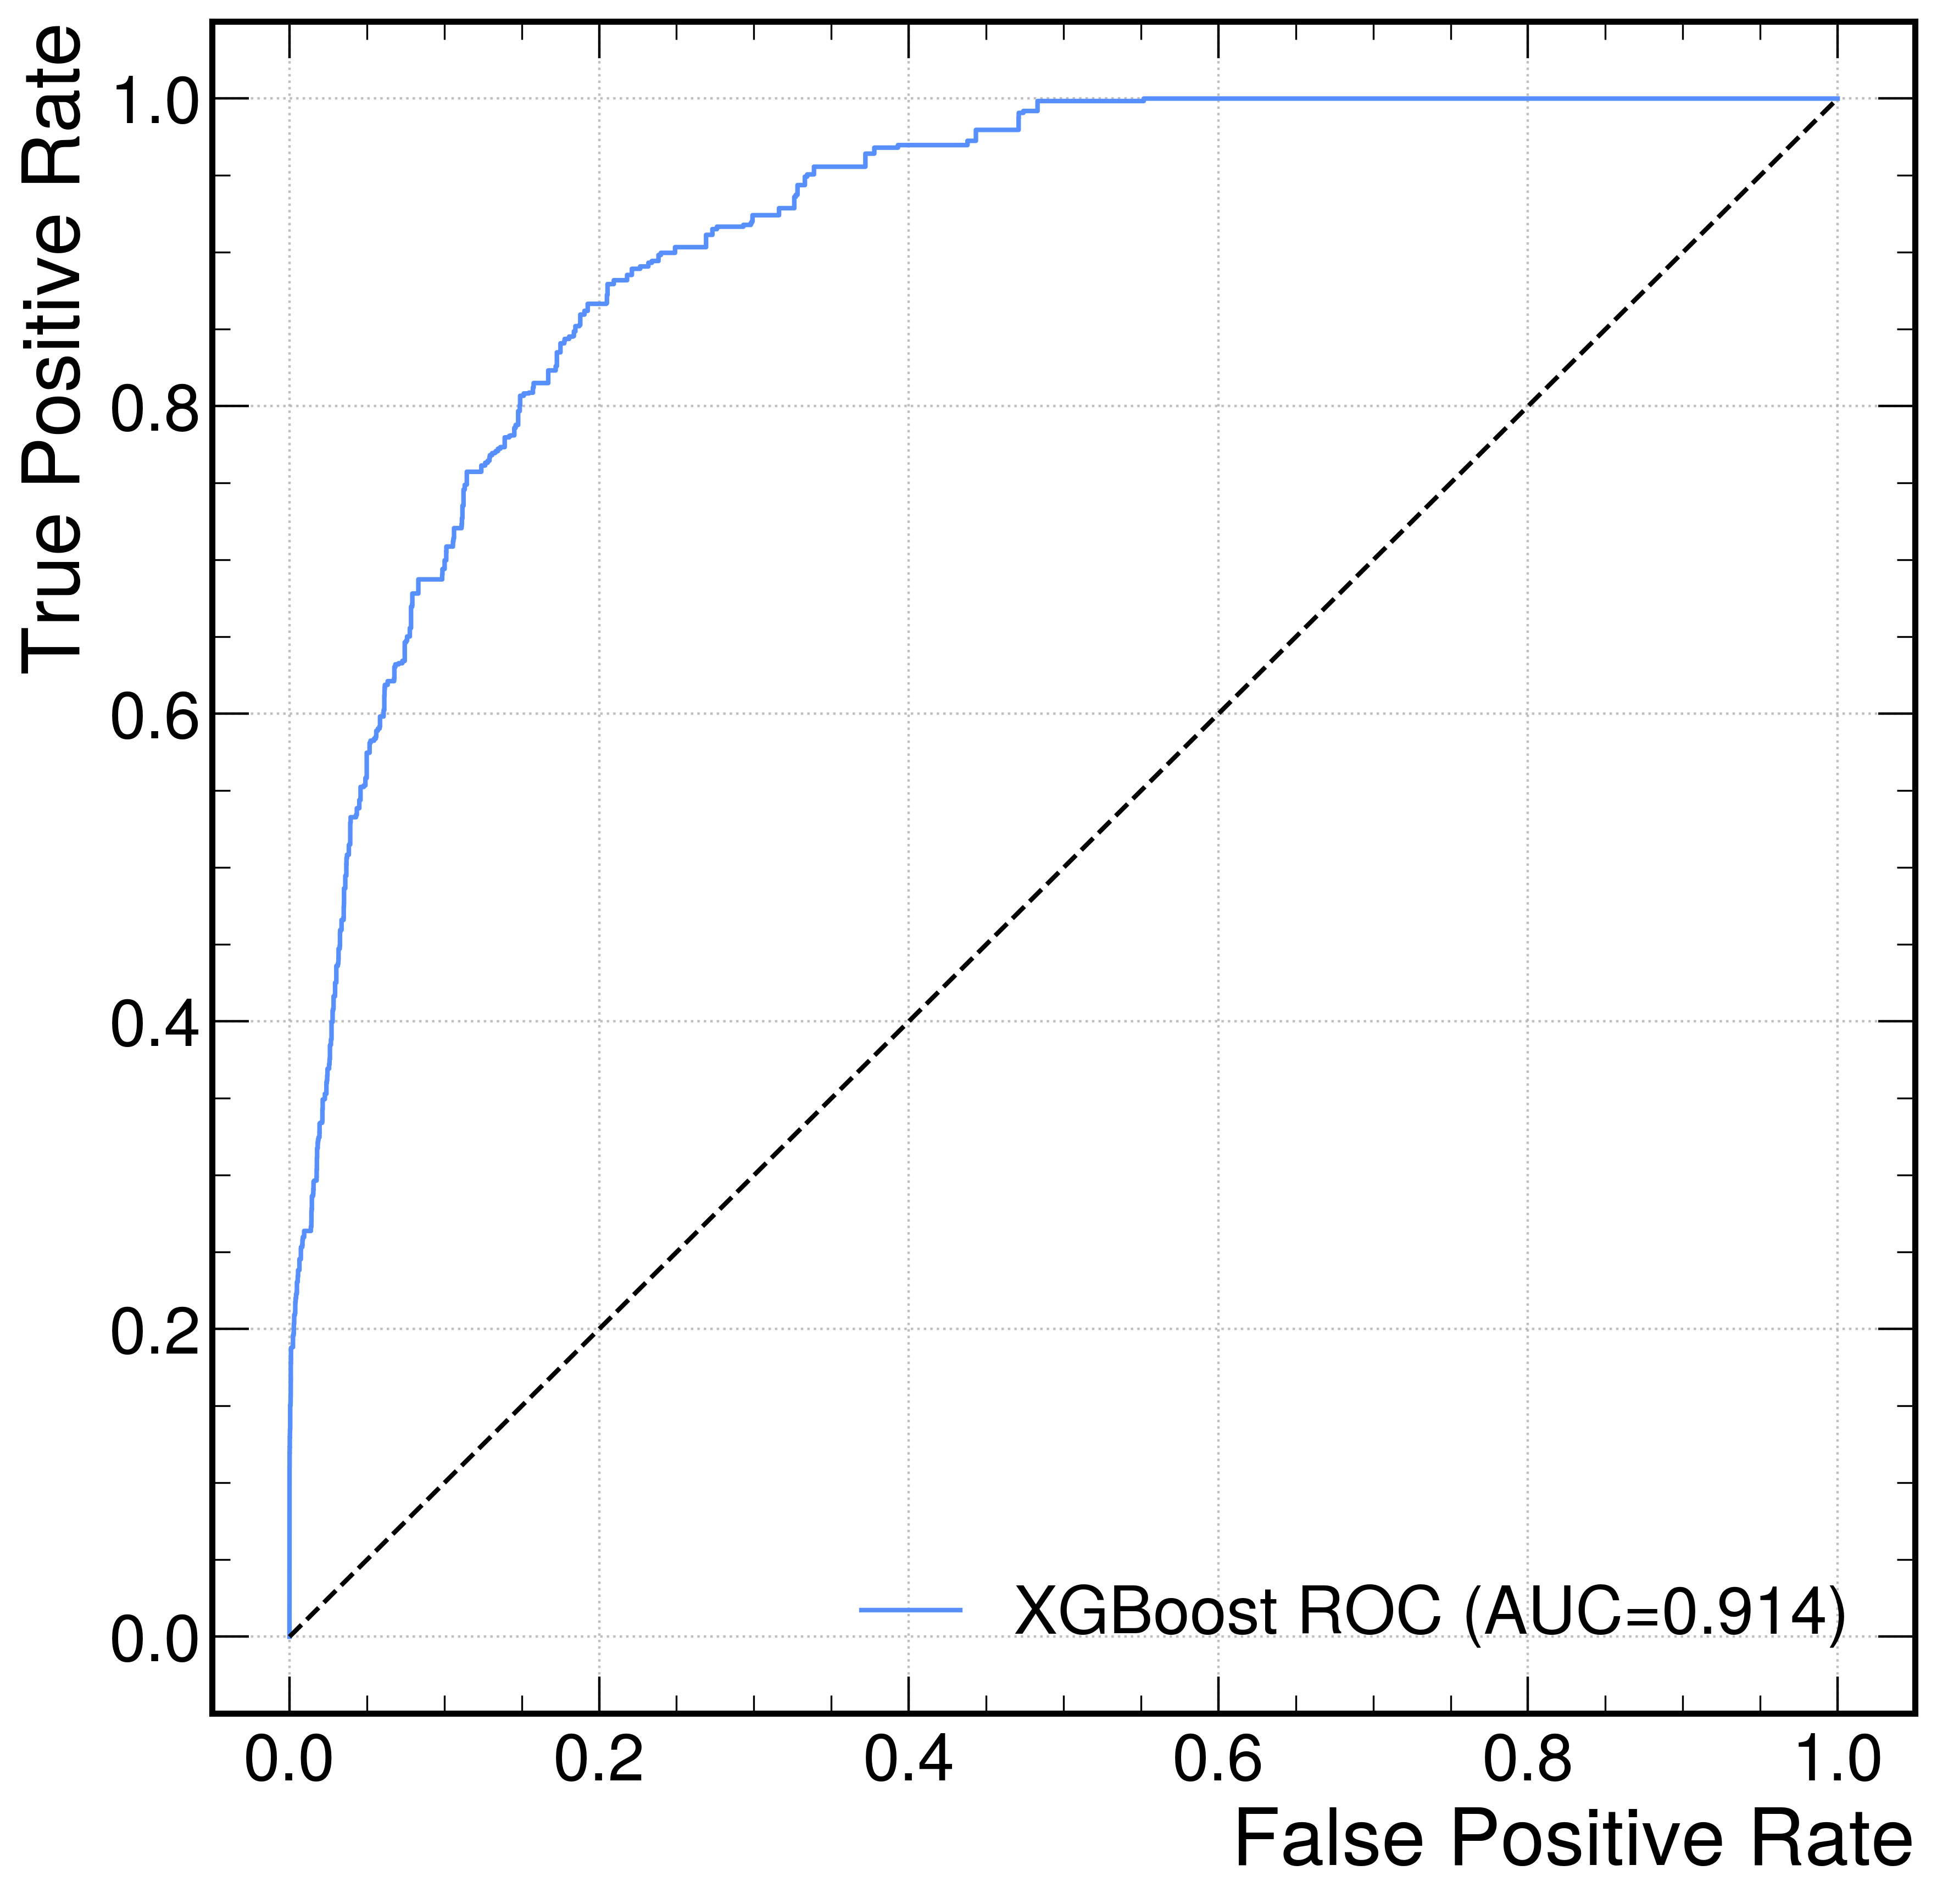

ROC curve saved to test-jn/xgb_roc_curve.png


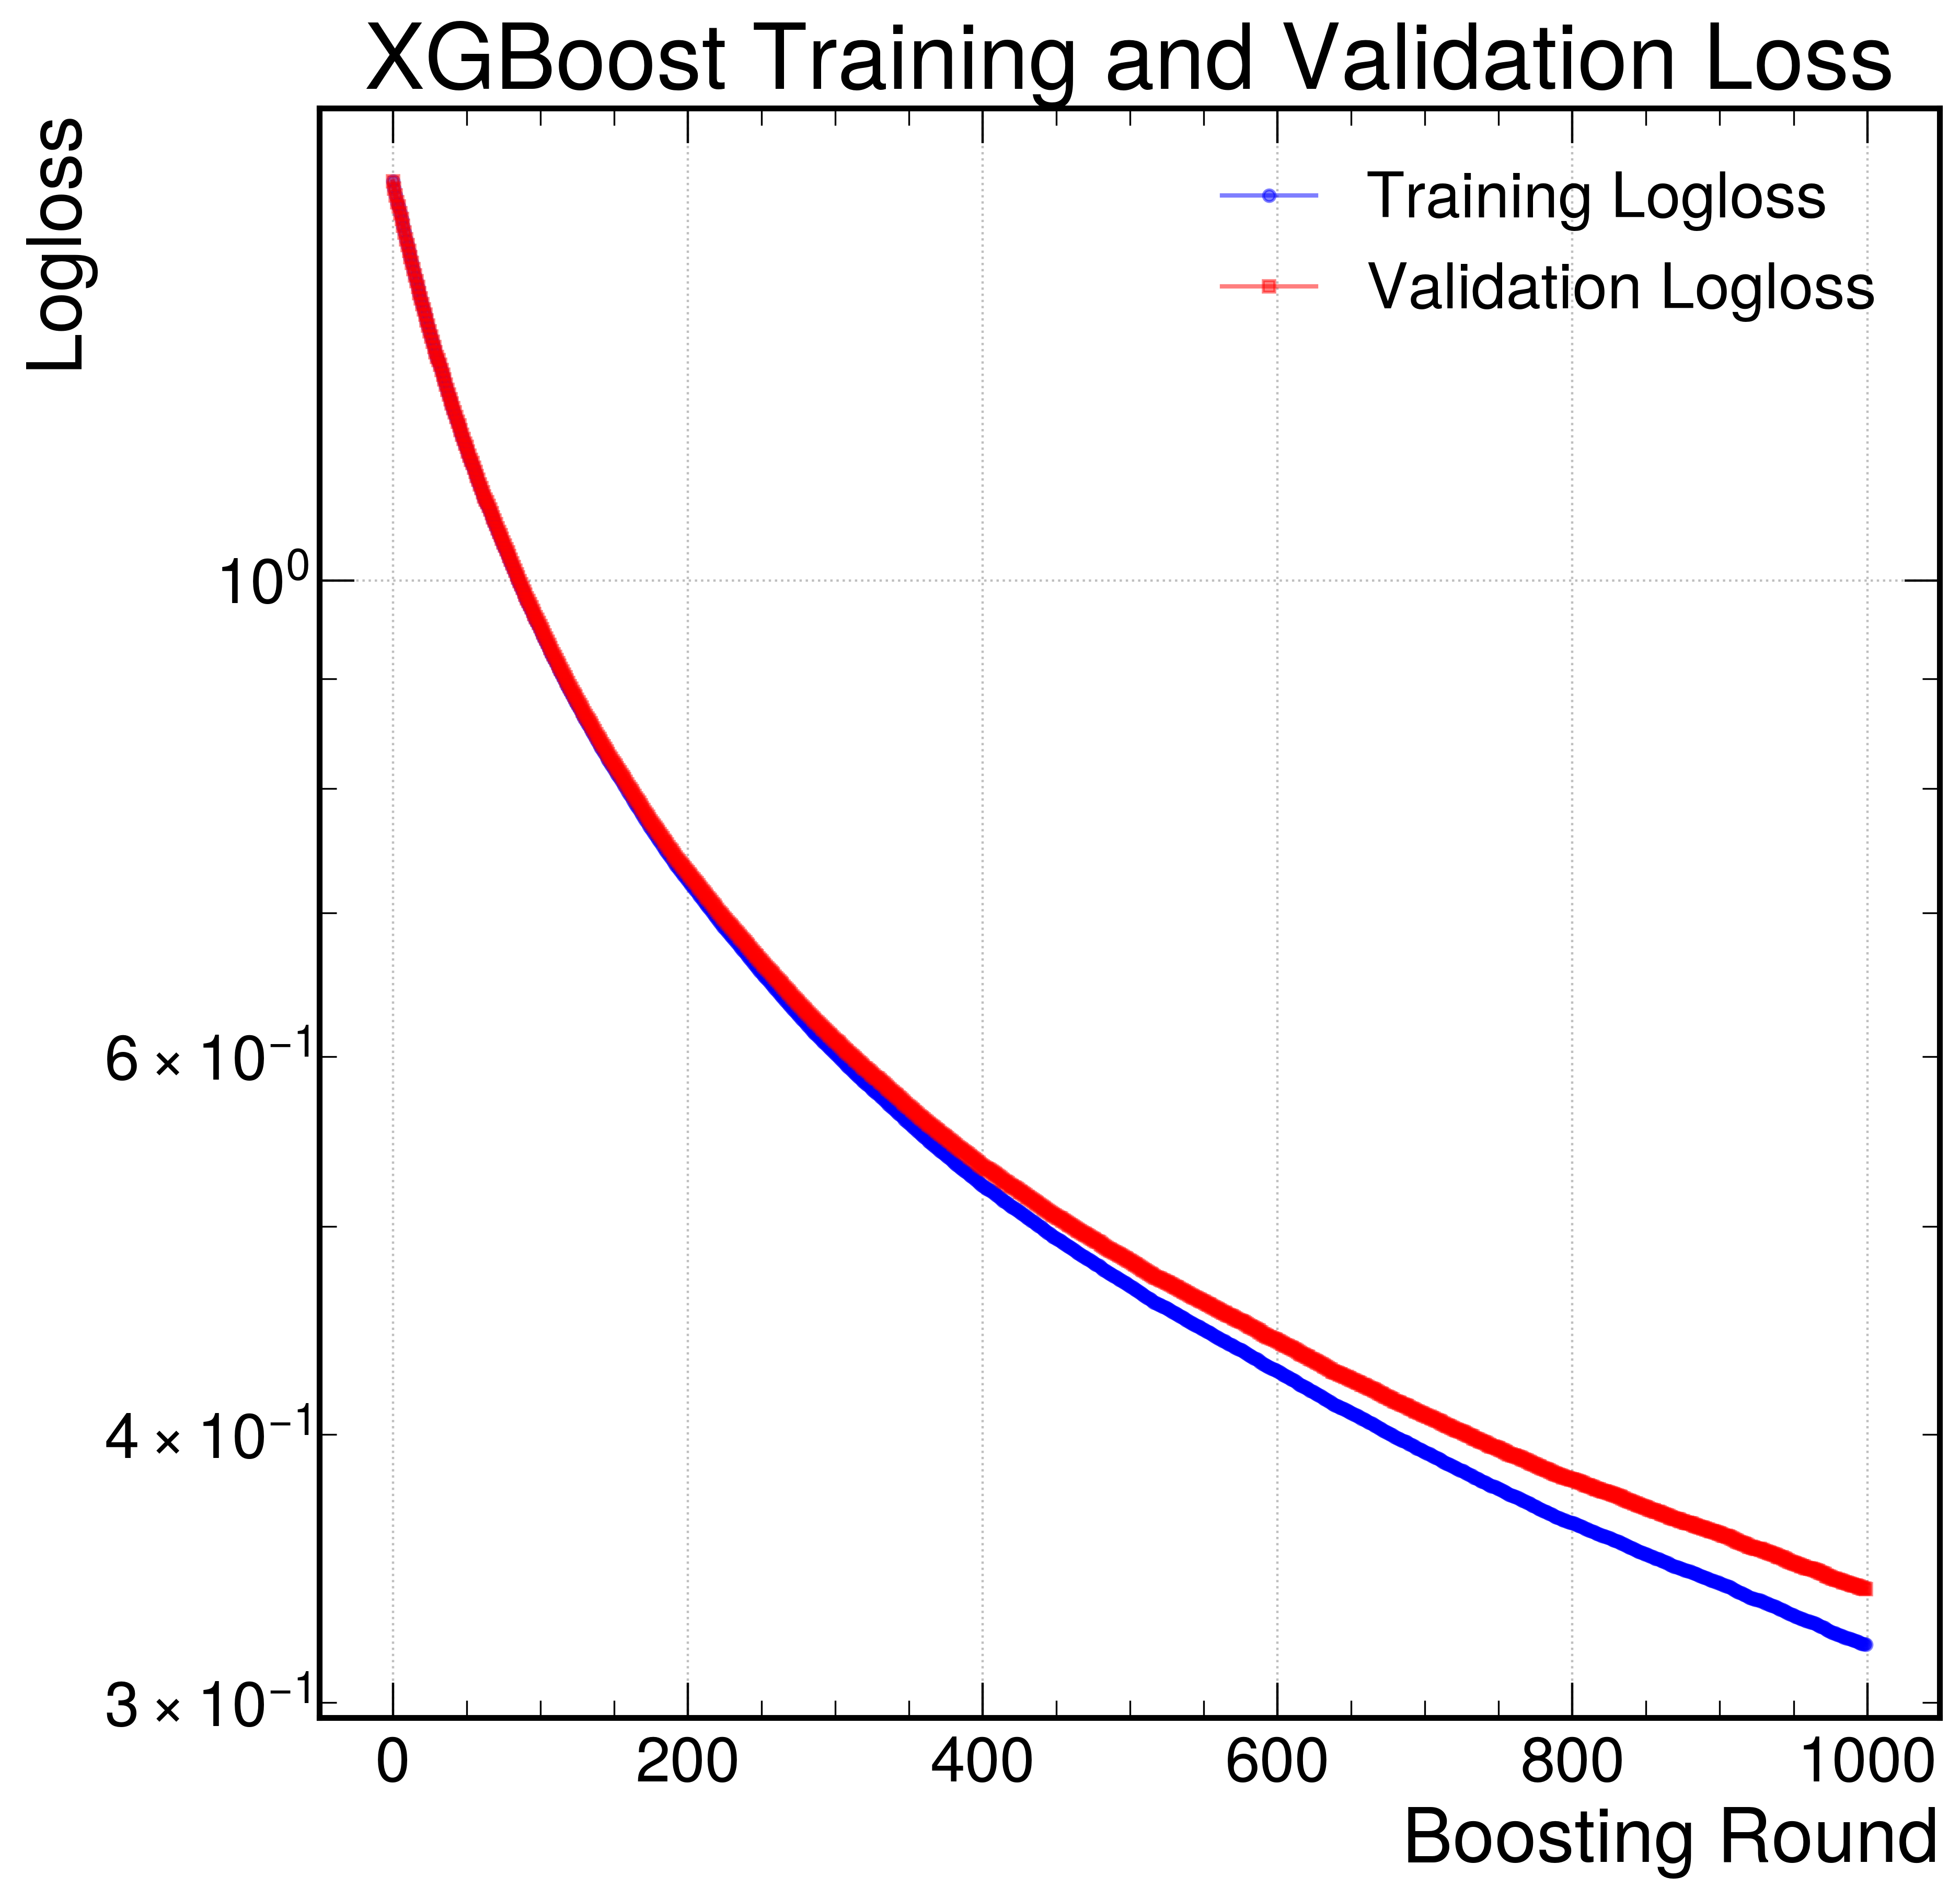

In [60]:
# obtain predictions
y_pred = model.predict_proba(X_test)[:, 1]
results = model.evals_result()

import matplotlib.pyplot as plt

# Predict and evaluate
roc_auc = roc_auc_score(y_test, y_pred, sample_weight=weights_test)
print(f"XGBoost ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred, sample_weight=weights_test)
plt.figure()
plt.plot(fpr, tpr, label=f"XGBoost ROC (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.savefig(f"{output_dir}/xgb_roc_curve.png")
plt.show()
print(f"ROC curve saved to {output_dir}/xgb_roc_curve.png")


plt.figure()
plt.plot(
    results["validation_0"]["logloss"],
    label="Training Logloss",
    color="blue",
    marker="o",
    markersize=4,
    alpha=0.5,
)
plt.plot(
    results["validation_1"]["logloss"],
    label="Validation Logloss",
    color="red",
    marker="s",
    markersize=4,
    alpha=0.5,
)
plt.xlabel("Boosting Round")
plt.ylabel("Logloss")
plt.title("XGBoost Training and Validation Loss")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.savefig(f"{output_dir}/xgb_loss_curve.png")
plt.show()

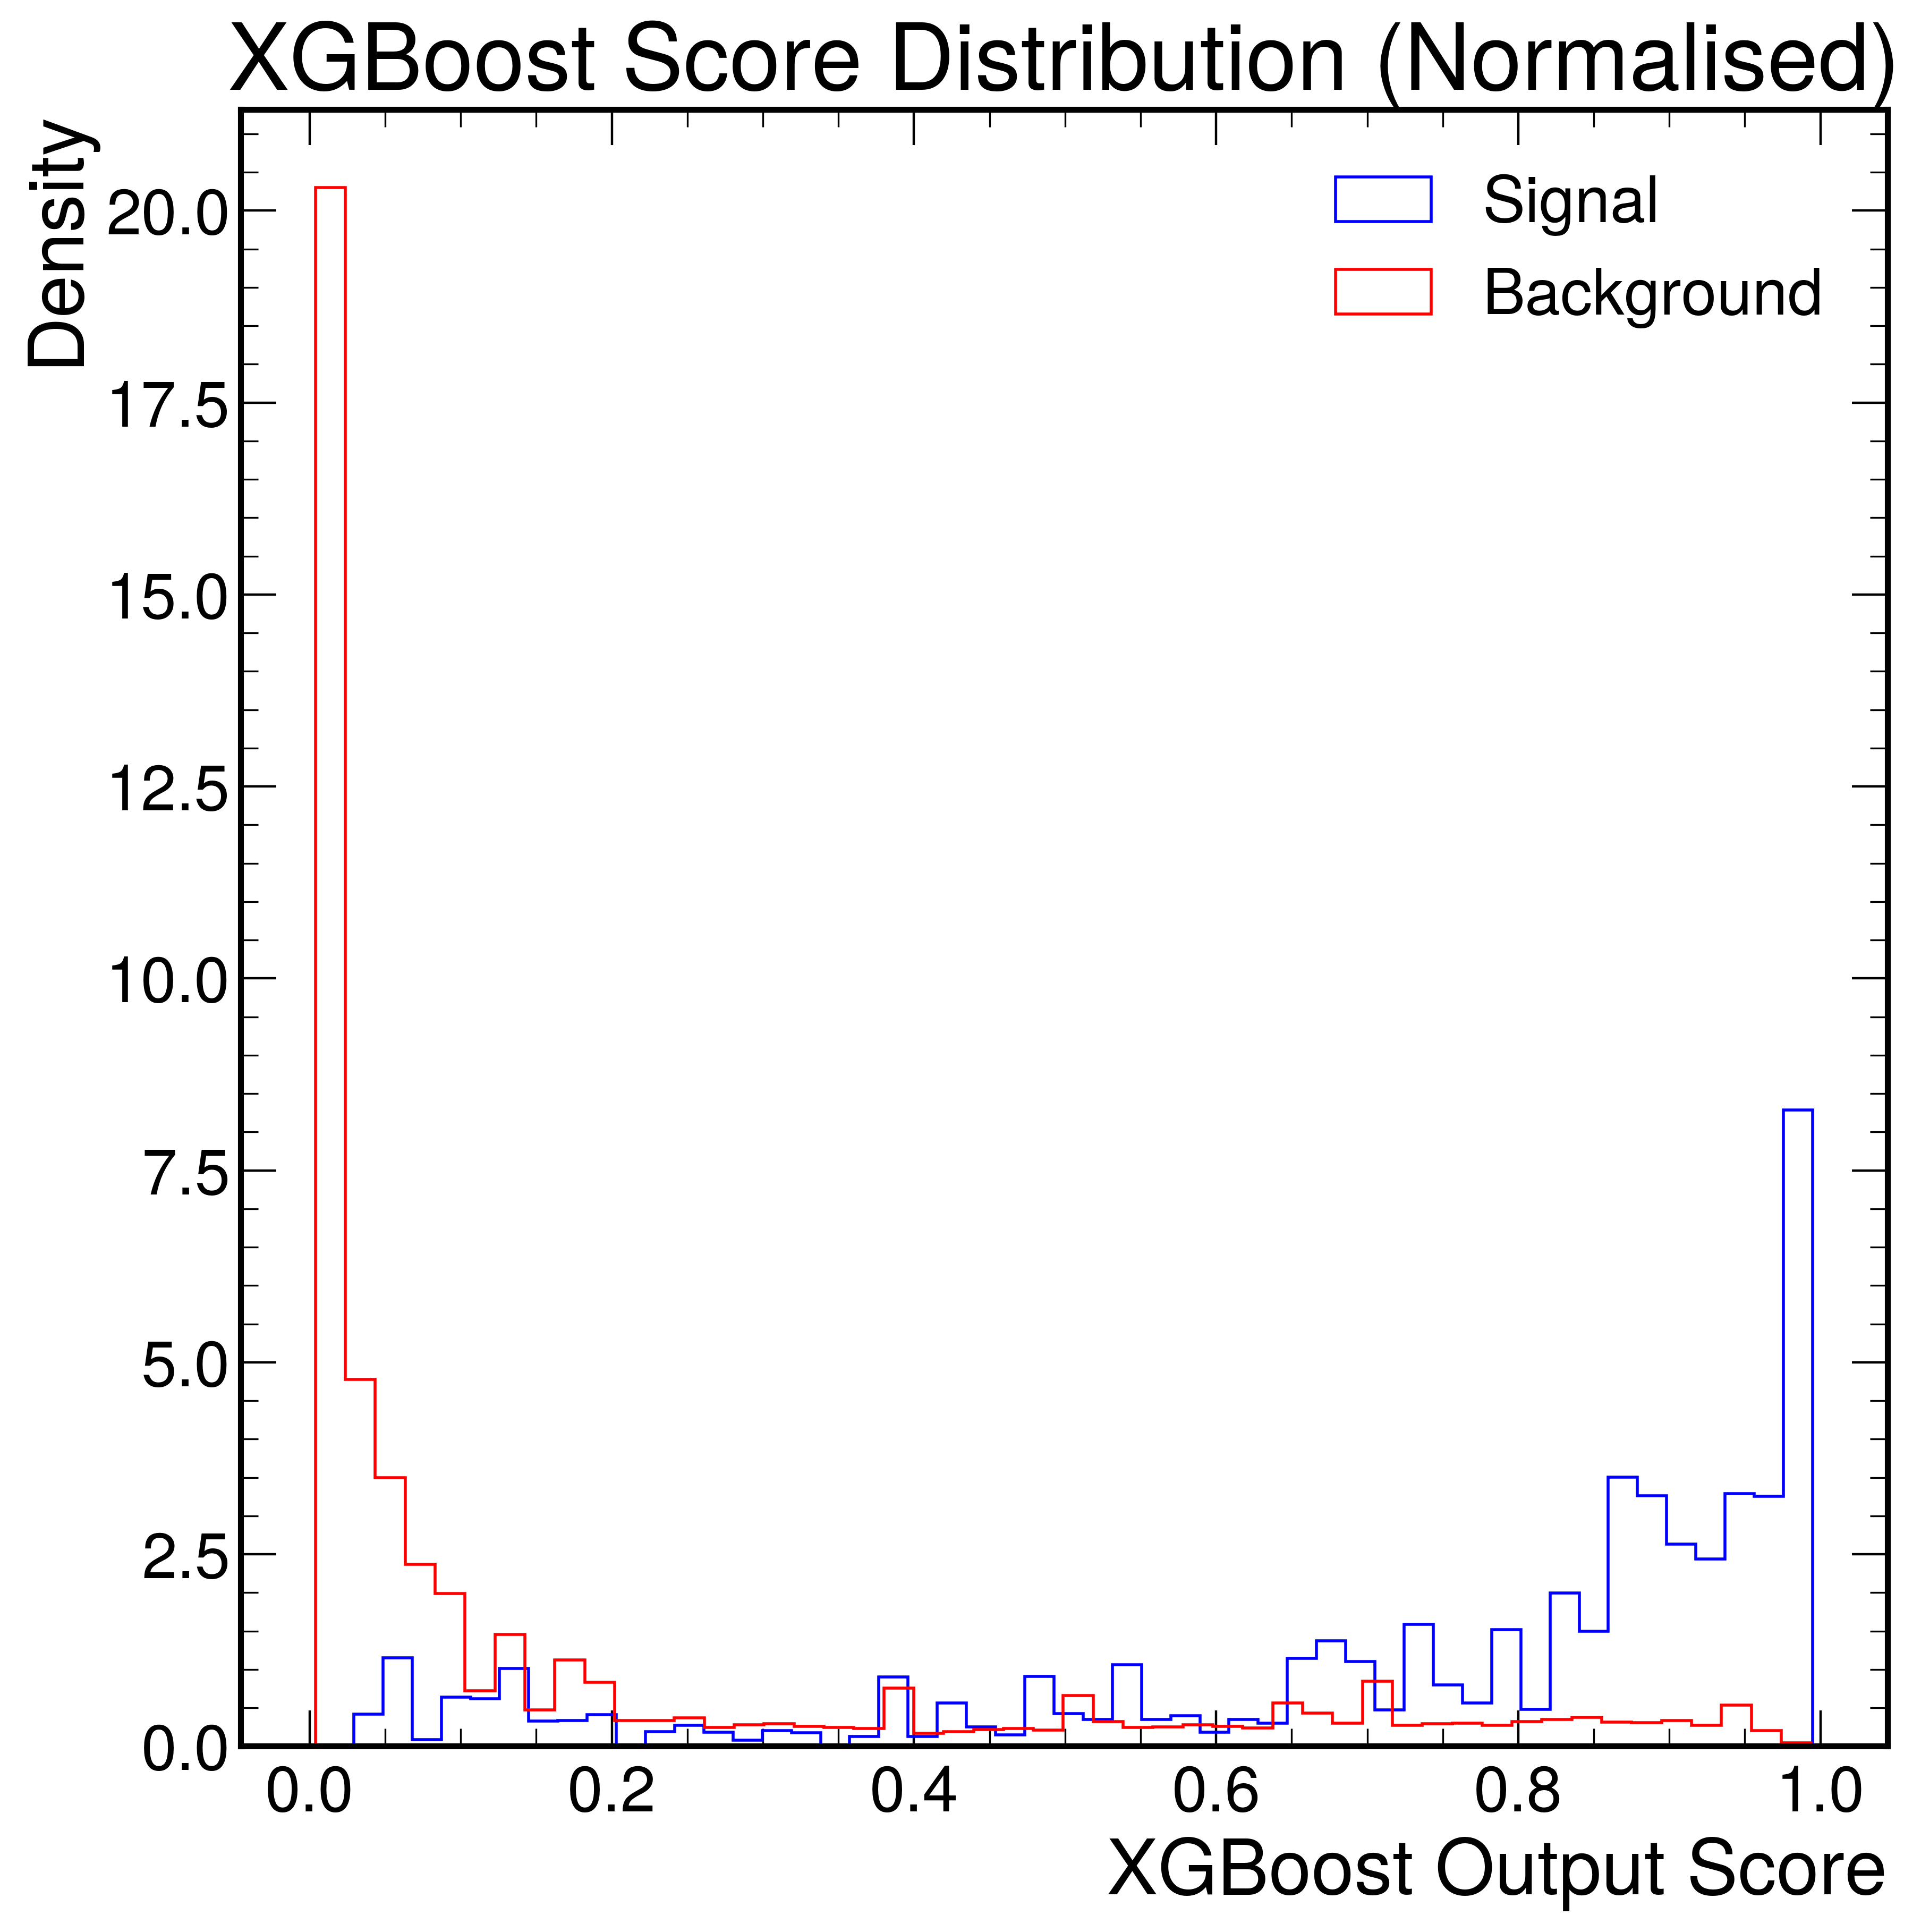

Score distribution saved to test-jn/xgb_score_dist_normalised.png


In [61]:
# Plot score distribution for signal and background (normalised)
plt.figure()
plt.hist(
    y_pred[y_test == 1],
    weights=weights_test[y_test == 1],
    bins=50,
    histtype="step",
    color="blue",
    label="Signal",
    density=True,  # Normalise histogram
)
plt.hist(
    y_pred[y_test == 0],
    weights=weights_test[y_test == 0],
    bins=50,
    histtype="step",
    color="red",
    label="Background",
    density=True,  # Normalise histogram
)
plt.xlabel("XGBoost Output Score")
plt.ylabel("Density")
plt.legend()
plt.title("XGBoost Score Distribution (Normalised)")
plt.savefig(f"{output_dir}/xgb_score_dist_normalised.png")
plt.show()
print(f"Score distribution saved to {output_dir}/xgb_score_dist_normalised.png")

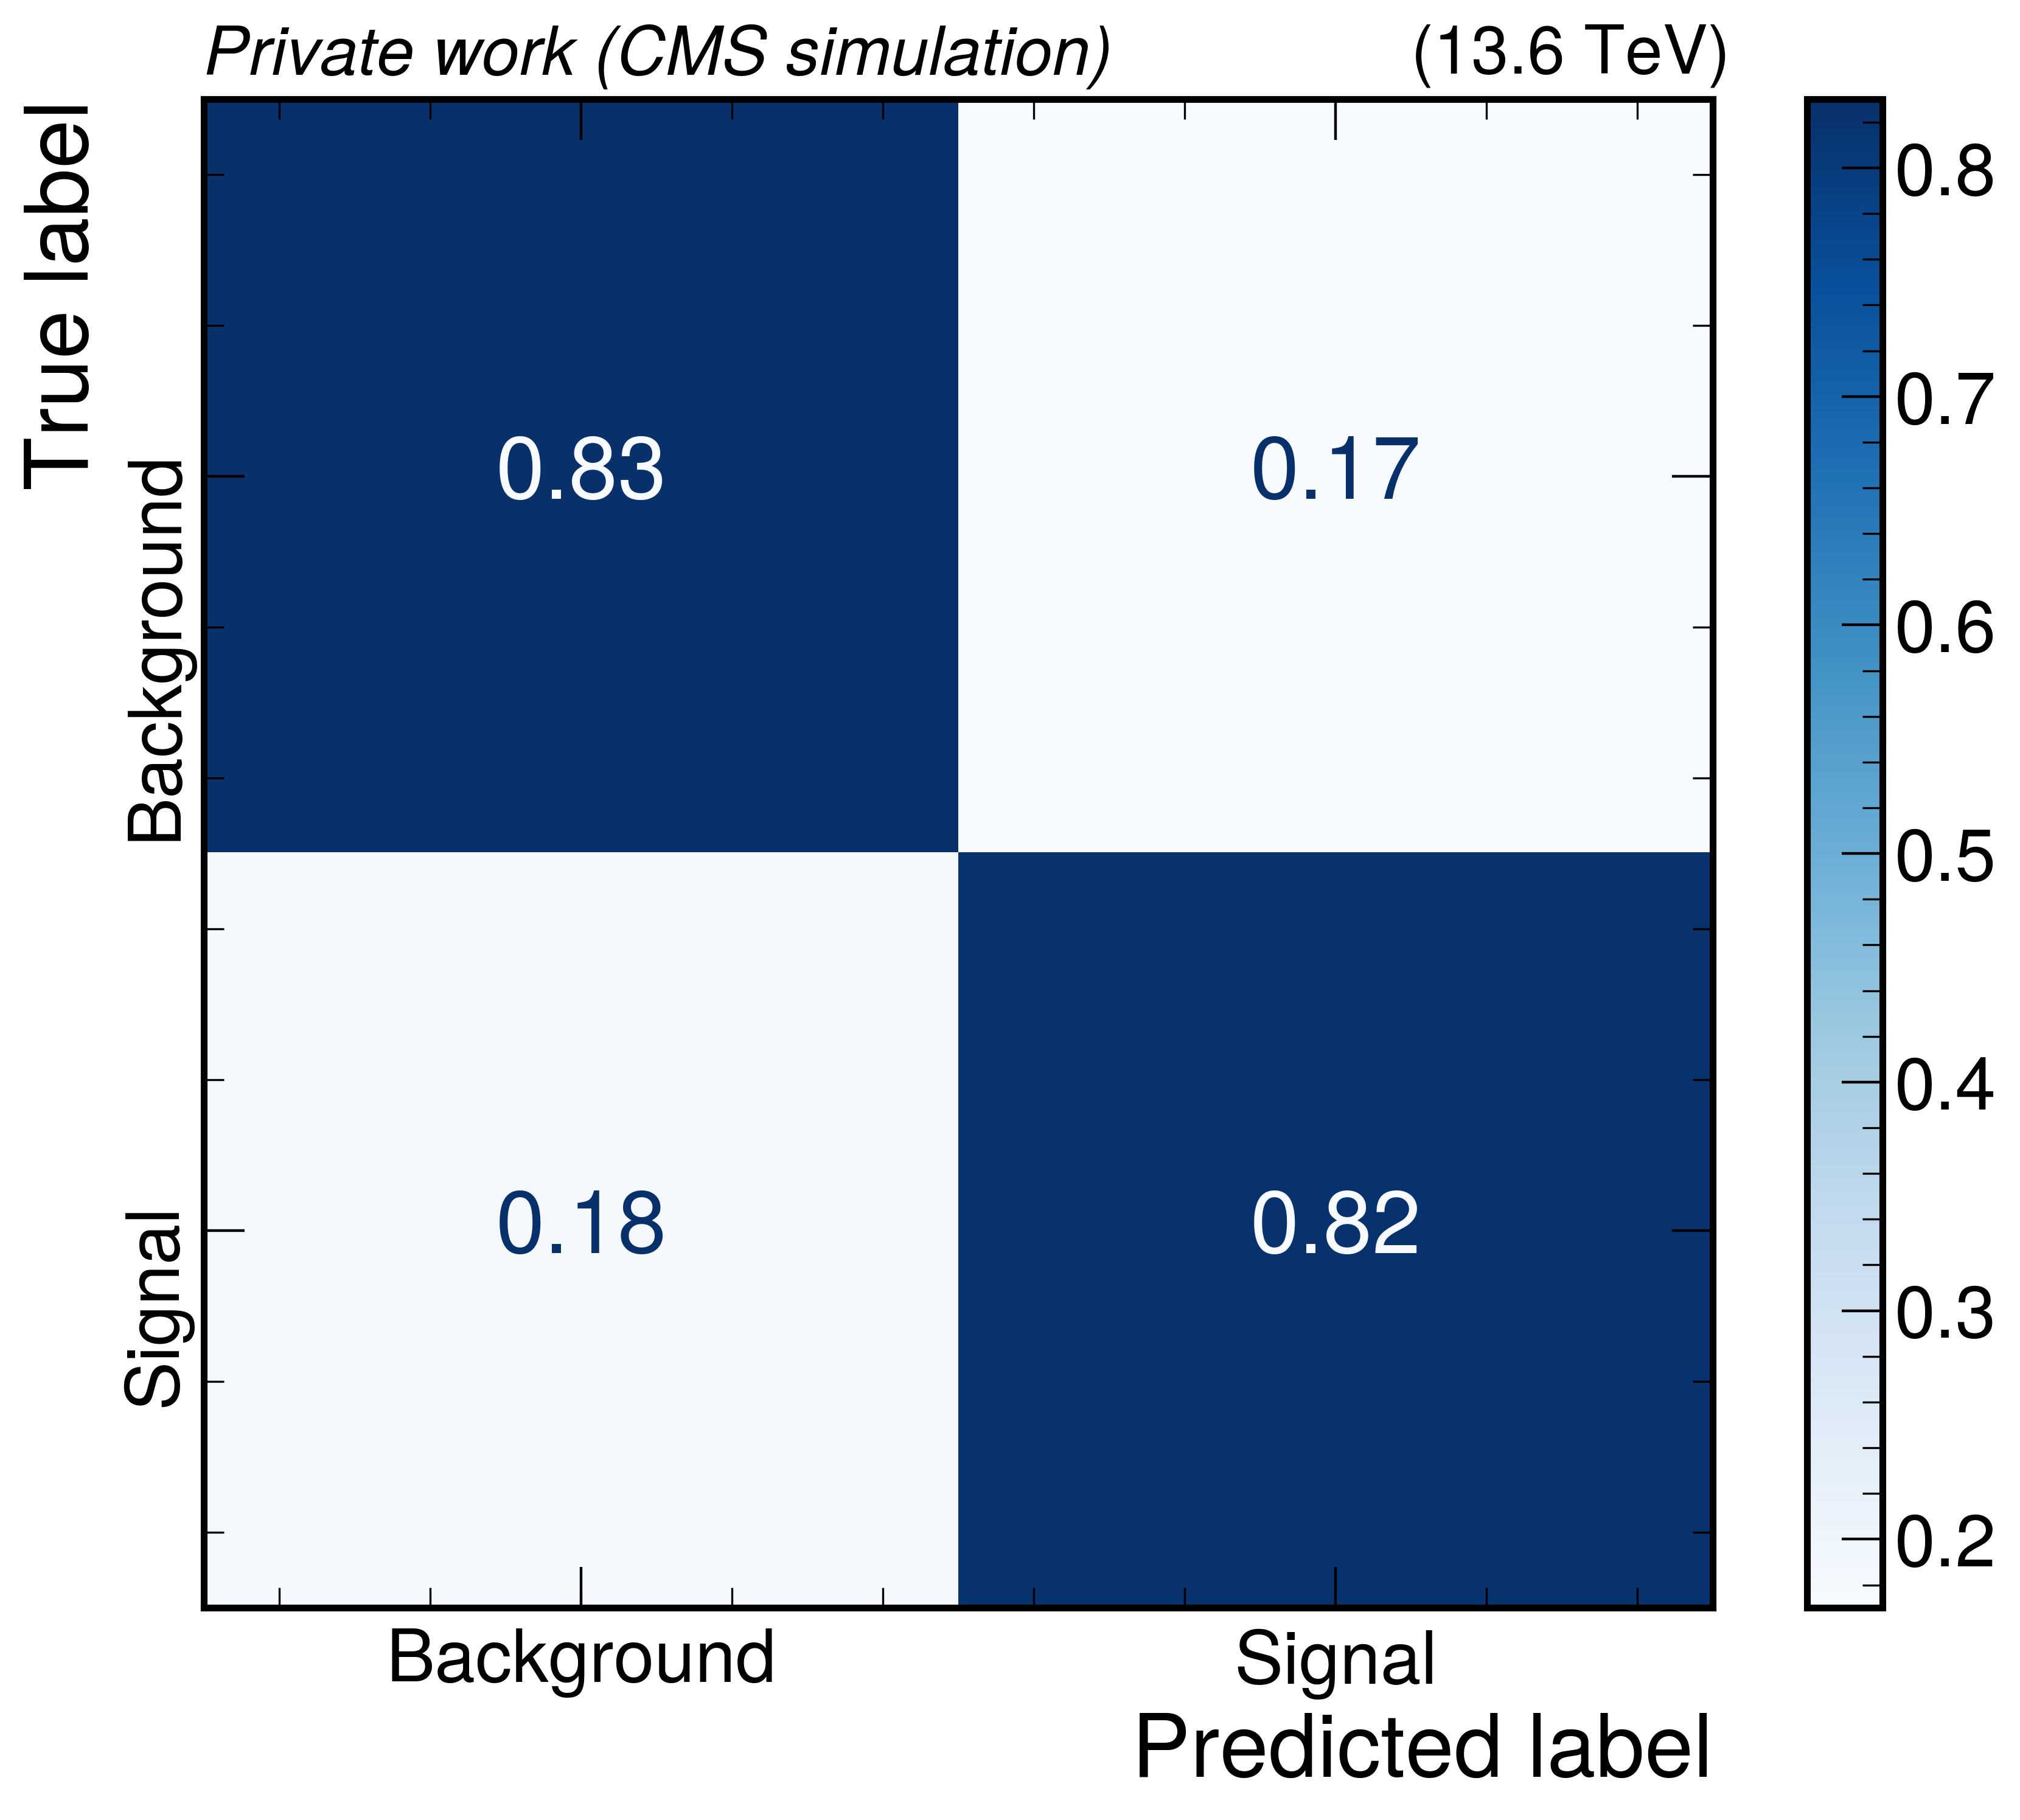

Confusion matrix saved to test-jn/xgb_confusion_matrix.png


In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class labels for validation set
y_pred_label = (y_pred > 0.5).astype(int)

# Compute confusion matrix (normalized)
cm = confusion_matrix(
    y_test, y_pred_label, sample_weight=weights_test, normalize="true"
)
display_labels = ["Background", "Signal"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap="Blues", values_format=".2f")
disp.ax_.set_yticklabels(display_labels, rotation=90)

disp.ax_.text(
    0.0,
    1.05,
    "Private work (CMS simulation)",
    fontsize=20,
    fontproperties="Tex Gyre Heros:italic",
    transform=disp.ax_.transAxes,
    verticalalignment="top",
)
disp.ax_.text(
    0.8,
    1.05,
    "(13.6 TeV)",
    fontsize=20,
    fontproperties="Tex Gyre Heros",
    transform=disp.ax_.transAxes,
    verticalalignment="top",
)

# Adjust colorbar to have the same height as the confusion matrix plot
cbar = disp.figure_.axes[-1]
cbar.set_position(
    [
        cbar.get_position().x0,
        disp.ax_.get_position().y0,
        cbar.get_position().width,
        disp.ax_.get_position().height,
    ]
)
plt.savefig(f"{output_dir}/xgb_confusion_matrix.png")
plt.show()
print(f"Confusion matrix saved to {output_dir}/xgb_confusion_matrix.png")

<Figure size 4000x2400 with 0 Axes>

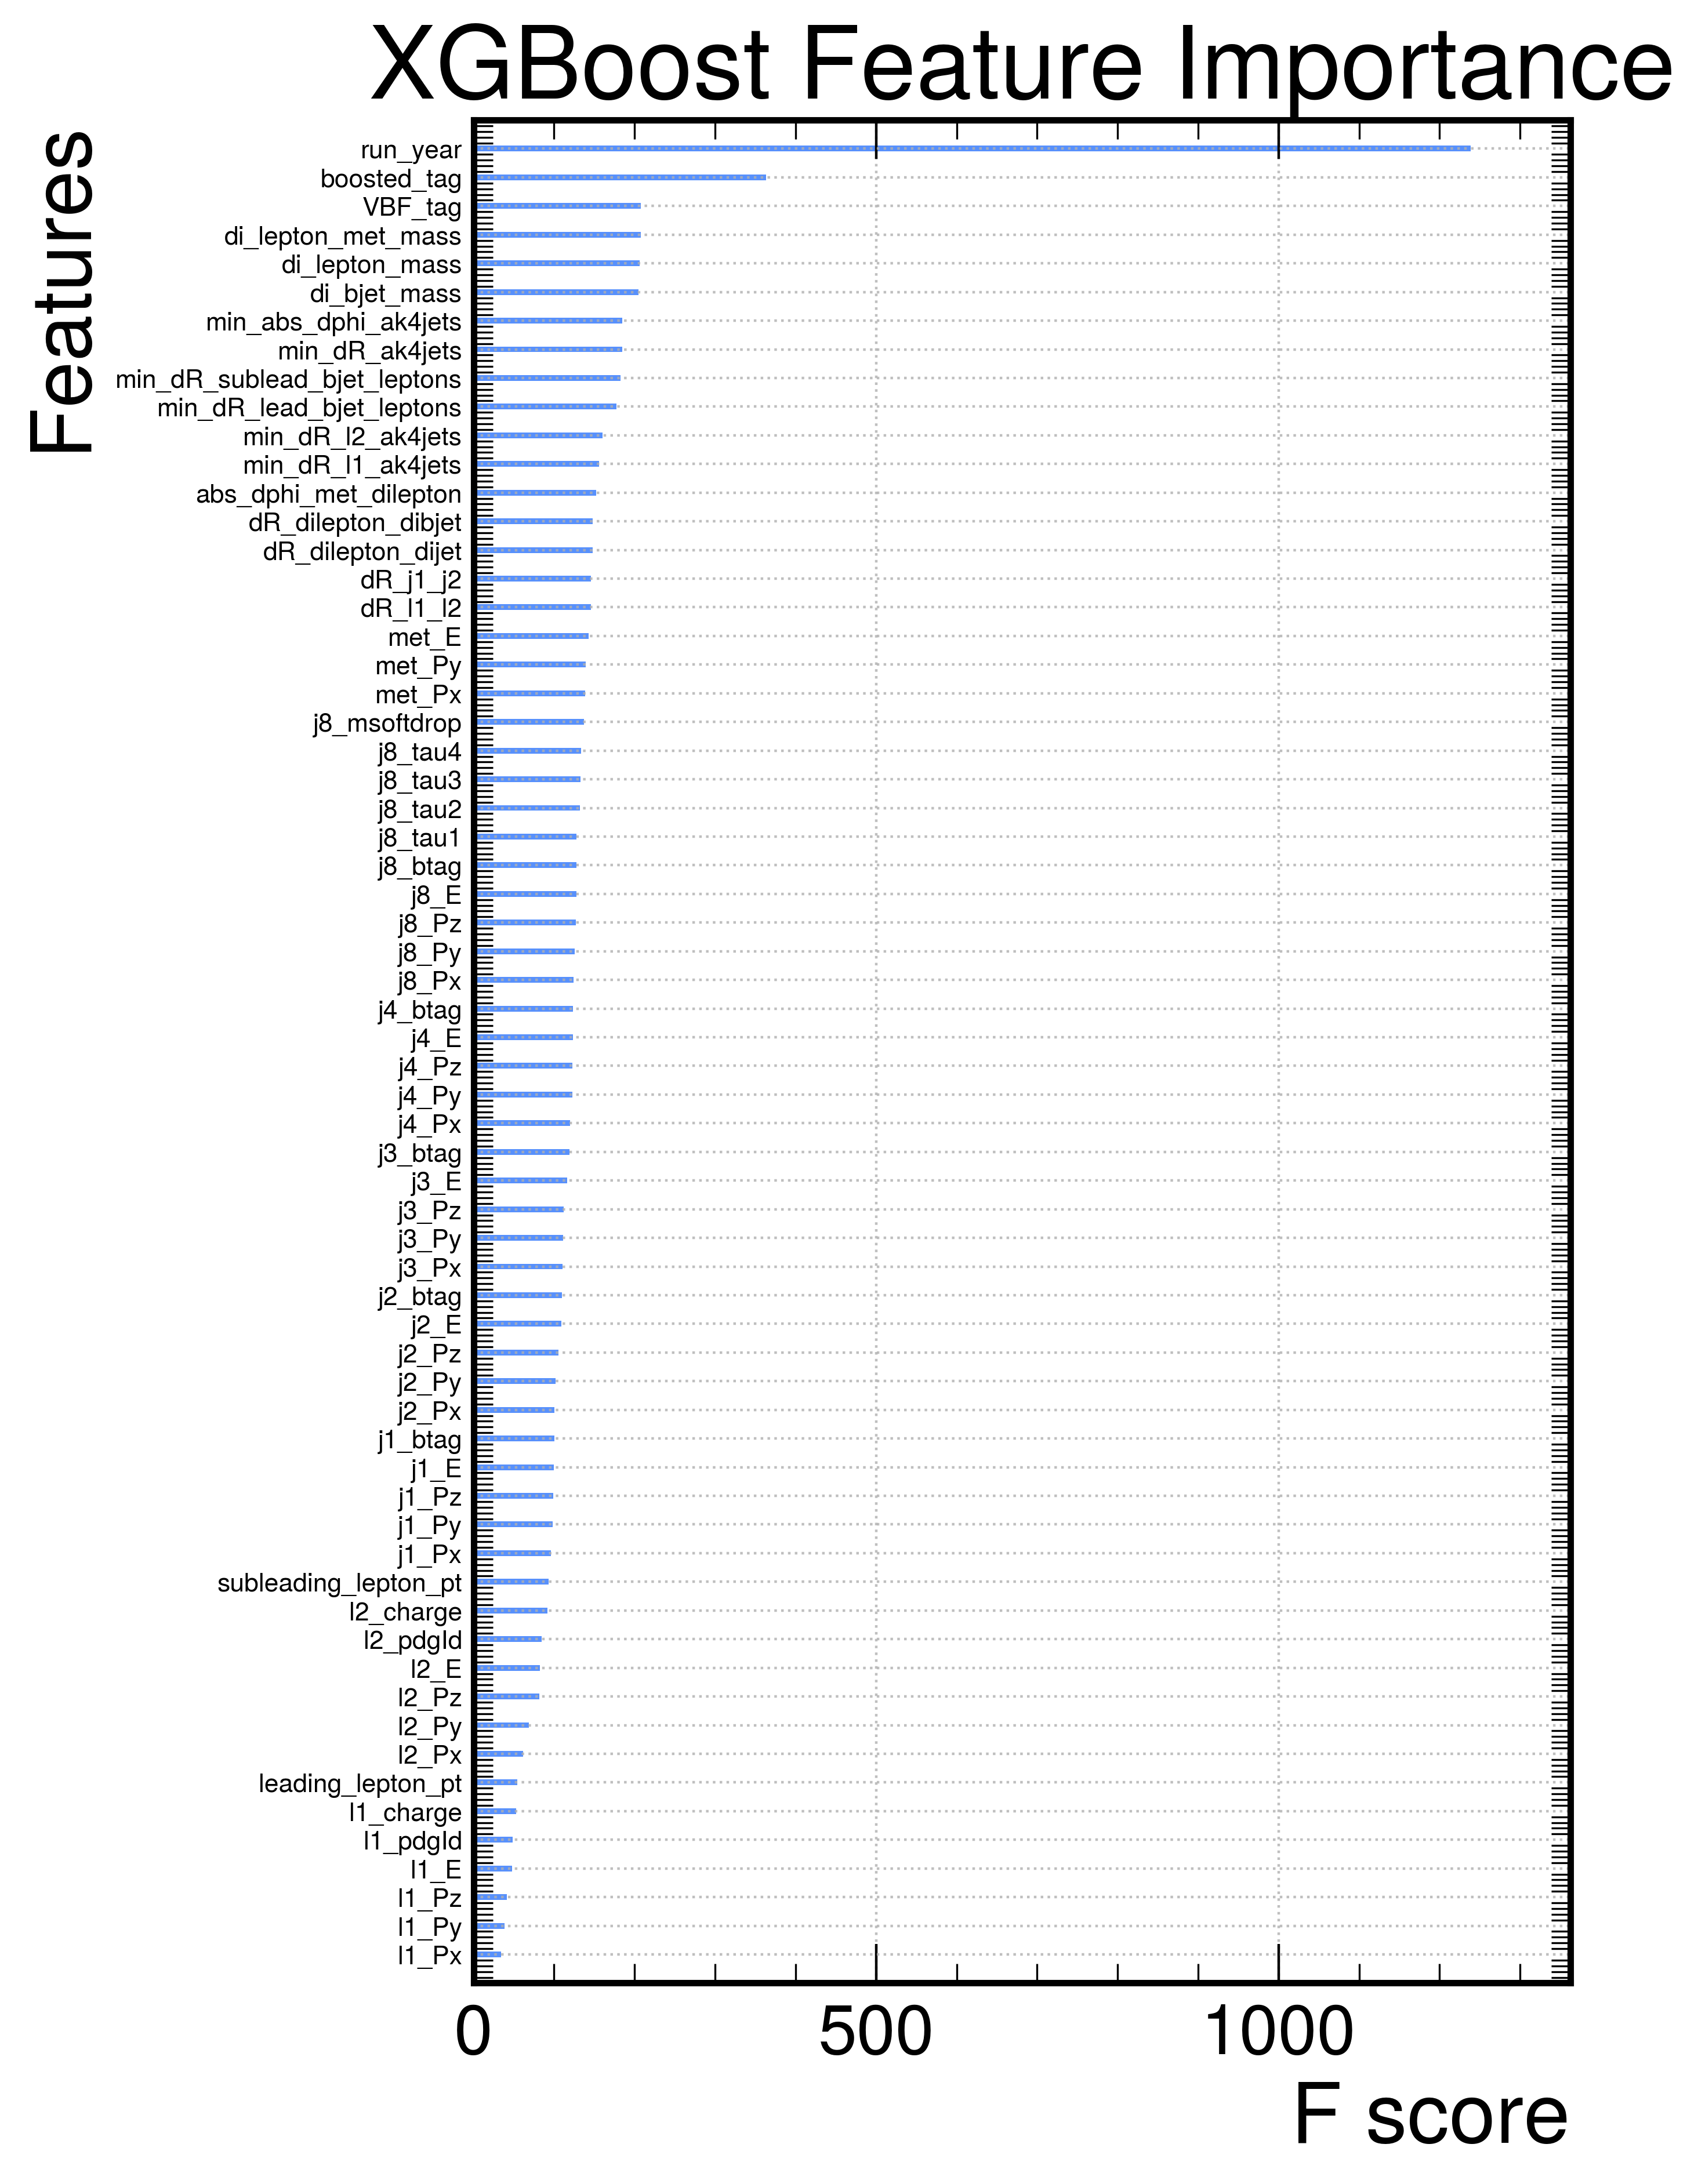

Feature importance plot saved to test-jn/xgb_feature_importance.png


In [63]:
from xgboost import plot_importance

# Plot feature importance with feature names
plt.figure(figsize=(10, 6))
ax = plot_importance(
    model,
    max_num_features=len(feature_cols),
    importance_type="gain",
    show_values=False,
)
feature_names = [col for col in df.columns if col not in ["HH", "bkg", "weight"]]
ax.set_yticklabels([feature_names[i] for i in range(len(ax.get_yticklabels()))])
plt.title("XGBoost Feature Importance")
plt.tight_layout()
ax.tick_params(axis="y", labelsize=8, length=0)  # Remove y-axis ticks
plt.savefig(f"{output_dir}/xgb_feature_importance.png")
plt.show()
print(f"Feature importance plot saved to {output_dir}/xgb_feature_importance.png")

In [64]:
# from sklearn.model_selection import StratifiedKFold

# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
#     print(f"Fold {fold+1}")
#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]
#     w_train, weights_test = weights[train_idx], weights[test_idx]

#     model.fit(
#         X_train,
#         y_train,
#         sample_weight=w_train,
#         eval_set=[(X_test, y_test)],
#         sample_weight_eval_set=[weights_test],
#         verbose=False,
#     )
#     y_pred = model.predict_proba(X_test)[:, 1]
#     roc_auc = roc_auc_score(y_test, y_pred, sample_weight=weights_test)
#     print(f"ROC AUC (fold {fold+1}): {roc_auc:.4f}")

In [65]:
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType

onnx_model = onnxmltools.convert_xgboost(
    model,
    initial_types=[("float_input", FloatTensorType([None, X_train.shape[1]]))],
)
onnx_path = f"{output_dir}/model.onnx"
with open(onnx_path, "wb") as f:
    f.write(onnx_model.SerializeToString())
print(f"XGBoost model exported to {onnx_path}")

XGBoost model exported to test-jn/model.onnx


In [66]:
import onnxruntime as ort
import numpy as np

sess = ort.InferenceSession(onnx_path)
input_name = sess.get_inputs()[0].name
output_names = [o.name for o in sess.get_outputs()]

# Example input: use a real sample from your training data
signal_sample = df[df.HH == 1].sample(n=1000, random_state=seed)[feature_cols].values
bkg_sample = df[df.bkg == 1].sample(n=1000, random_state=seed)[feature_cols].values

signal_outputs = sess.run(output_names, {input_name: signal_sample.astype(np.float32)})
bkg_outputs = sess.run(output_names, {input_name: bkg_sample.astype(np.float32)})
signal_probs = signal_outputs[1]
bkg_probs = bkg_outputs[1]

KeyboardInterrupt: 

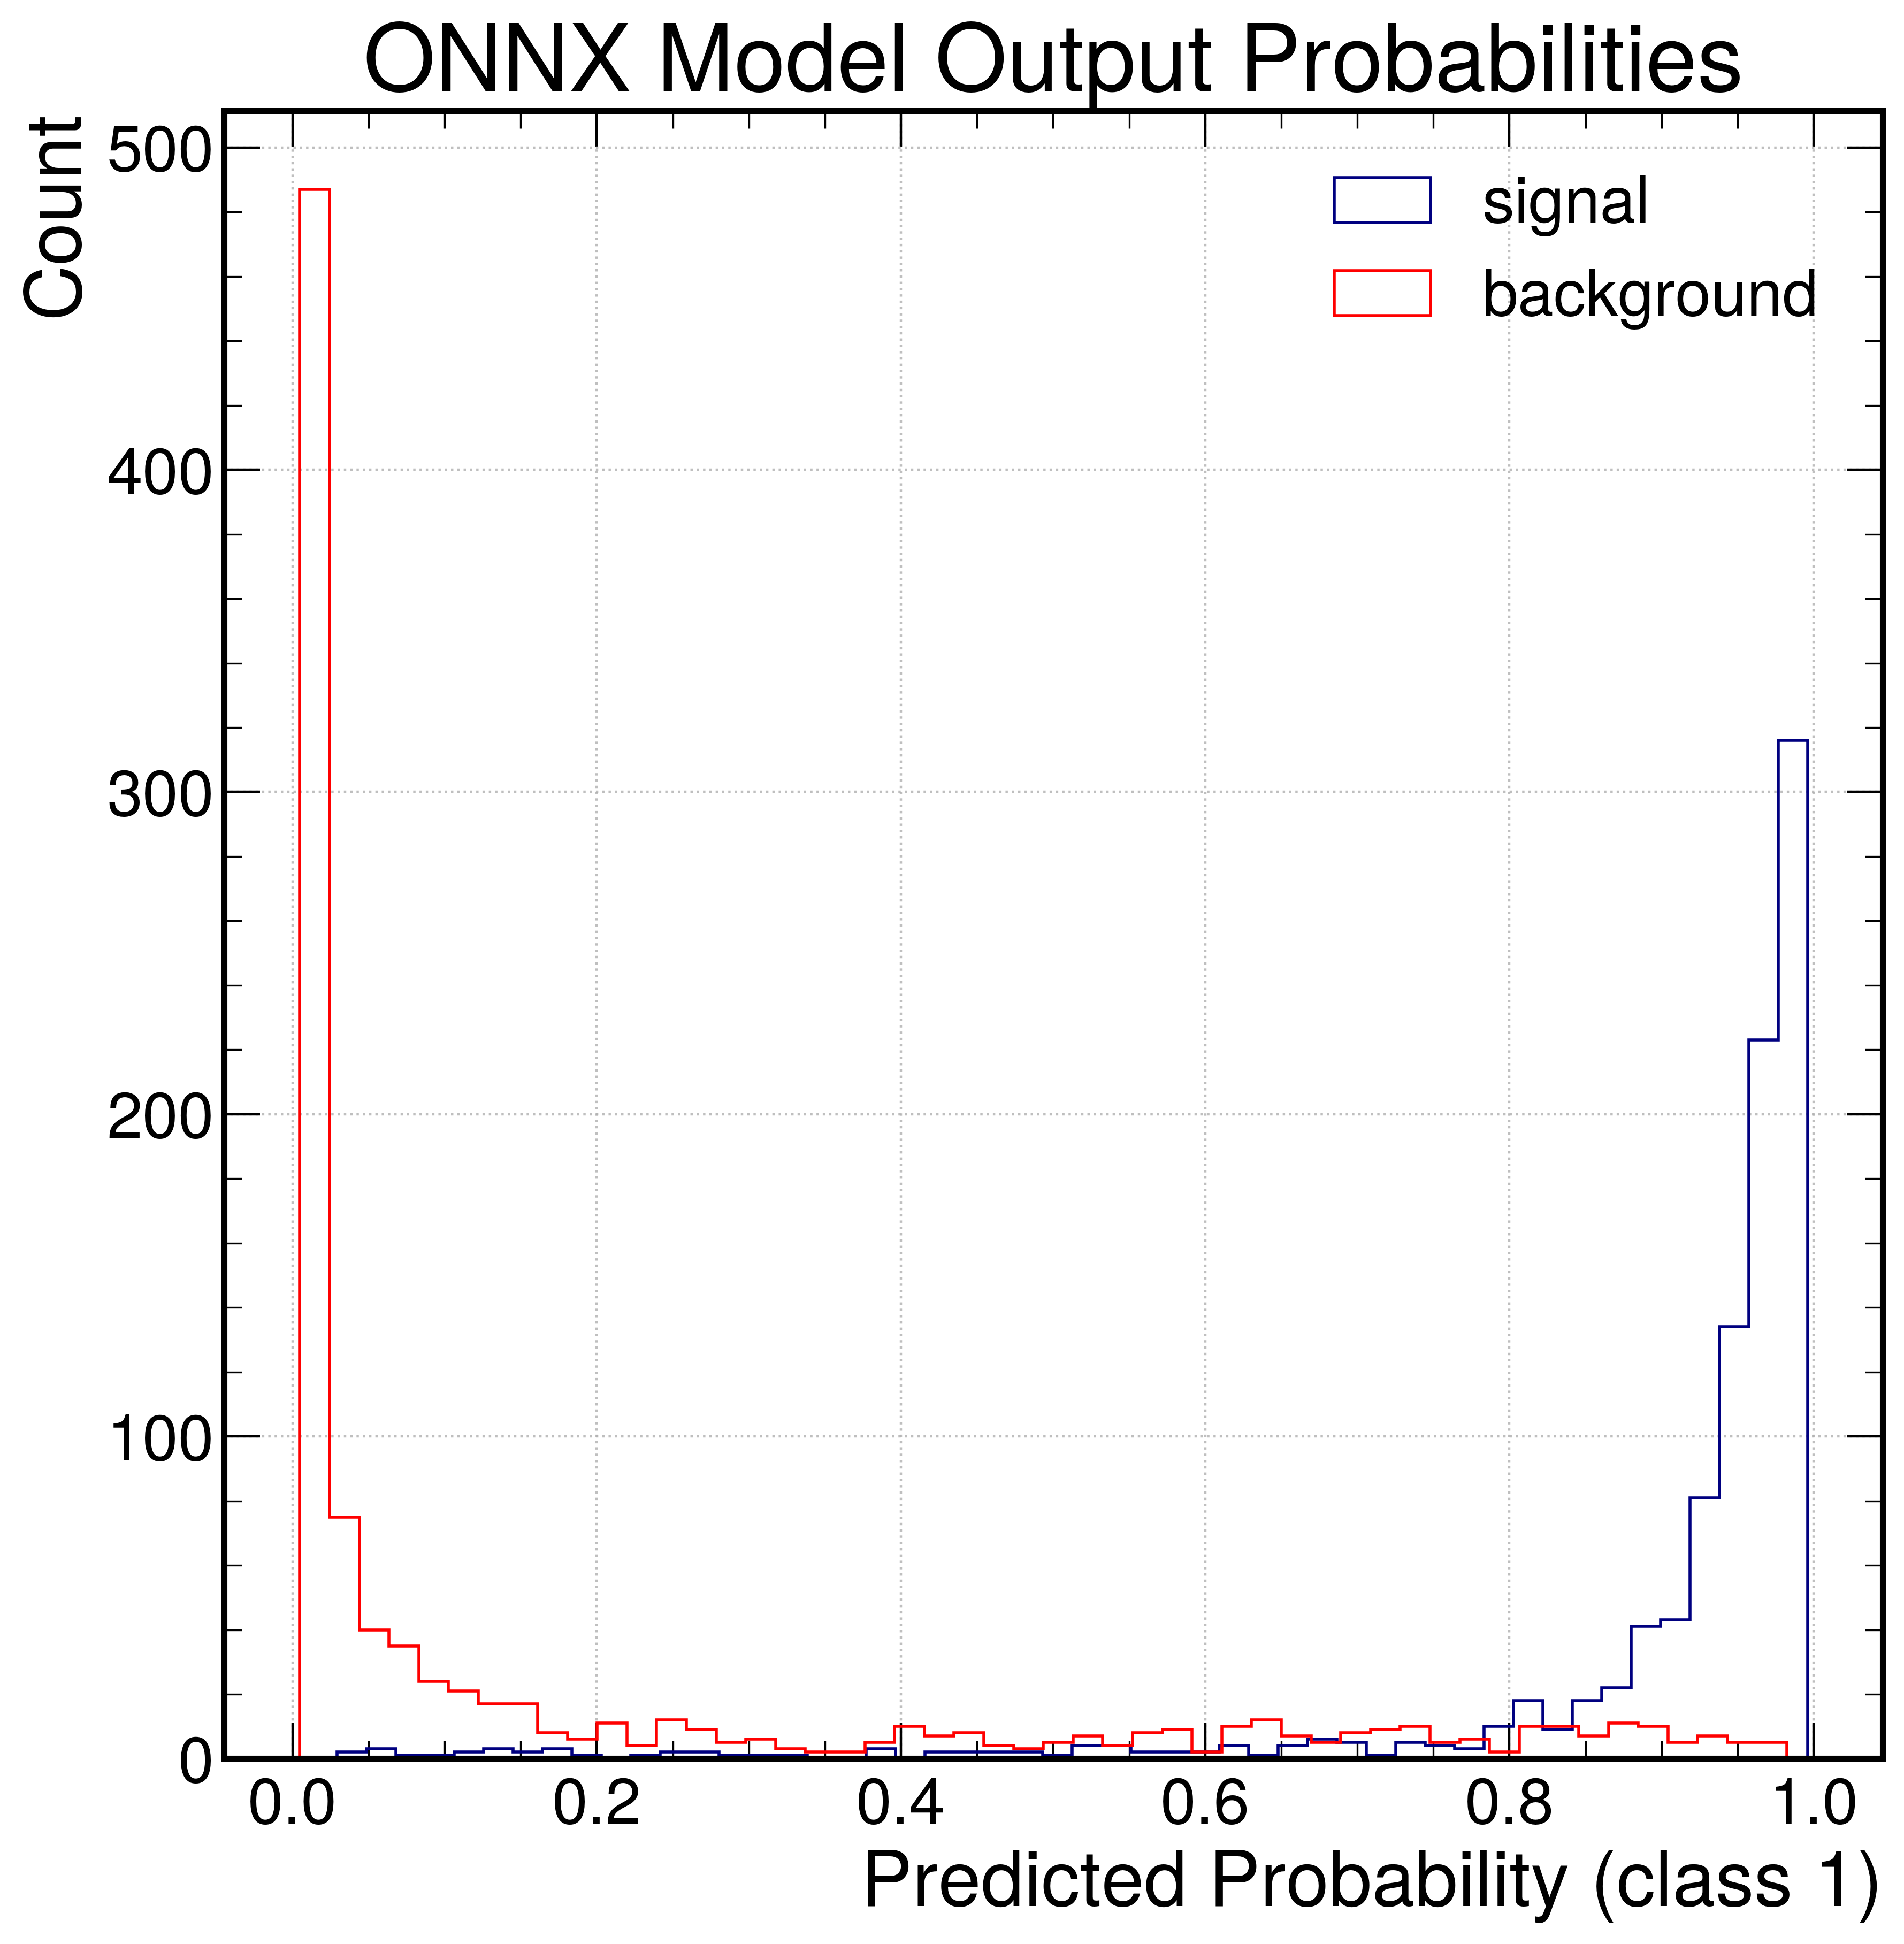

In [67]:
plt.figure()
plt.hist(
    signal_probs[:, 1],
    bins=50,
    color="skyblue",
    histtype="step",
    edgecolor="navy",
    label="signal",
)
plt.hist(
    bkg_probs[:, 1],
    bins=50,
    color="salmon",
    histtype="step",
    edgecolor="red",
    label="background",
)
plt.xlabel("Predicted Probability (class 1)")
plt.ylabel("Count")
plt.title("ONNX Model Output Probabilities")
plt.grid(True)
plt.legend()
plt.savefig(f"{output_dir}/onnx_model_output_probs.png")
print(f"ONNX model output probabilities saved to {output_dir}/onnx_model_output_probs.png")